C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Starting Evaluation on cuda...
 Loading 'tanganke/stanford_cars' from Hugging Face Hub...
✅ Data Split: 6515 Train | 1629 Val | 8041 Test
Loading class names from Hugging Face...
Loading weights from vgg19_hf_stanford_cars.pth...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20604\646789166.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=D

Running Inference...
   Processed batch 0/252...
   Processed batch 10/252...
   Processed batch 20/252...
   Processed batch 30/252...
   Processed batch 40/252...
   Processed batch 50/252...
   Processed batch 60/252...
   Processed batch 70/252...
   Processed batch 80/252...
   Processed batch 90/252...
   Processed batch 100/252...
   Processed batch 110/252...
   Processed batch 120/252...
   Processed batch 130/252...
   Processed batch 140/252...
   Processed batch 150/252...
   Processed batch 160/252...
   Processed batch 170/252...
   Processed batch 180/252...
   Processed batch 190/252...
   Processed batch 200/252...
   Processed batch 210/252...
   Processed batch 220/252...
   Processed batch 230/252...
   Processed batch 240/252...
   Processed batch 250/252...

       TEST RESULTS       
✅ Overall Accuracy: 46.81%

📊 Generating Detailed Report...

--- Top 5 Best Classified Cars ---
                                                 precision    recall  \
smart fortwo C

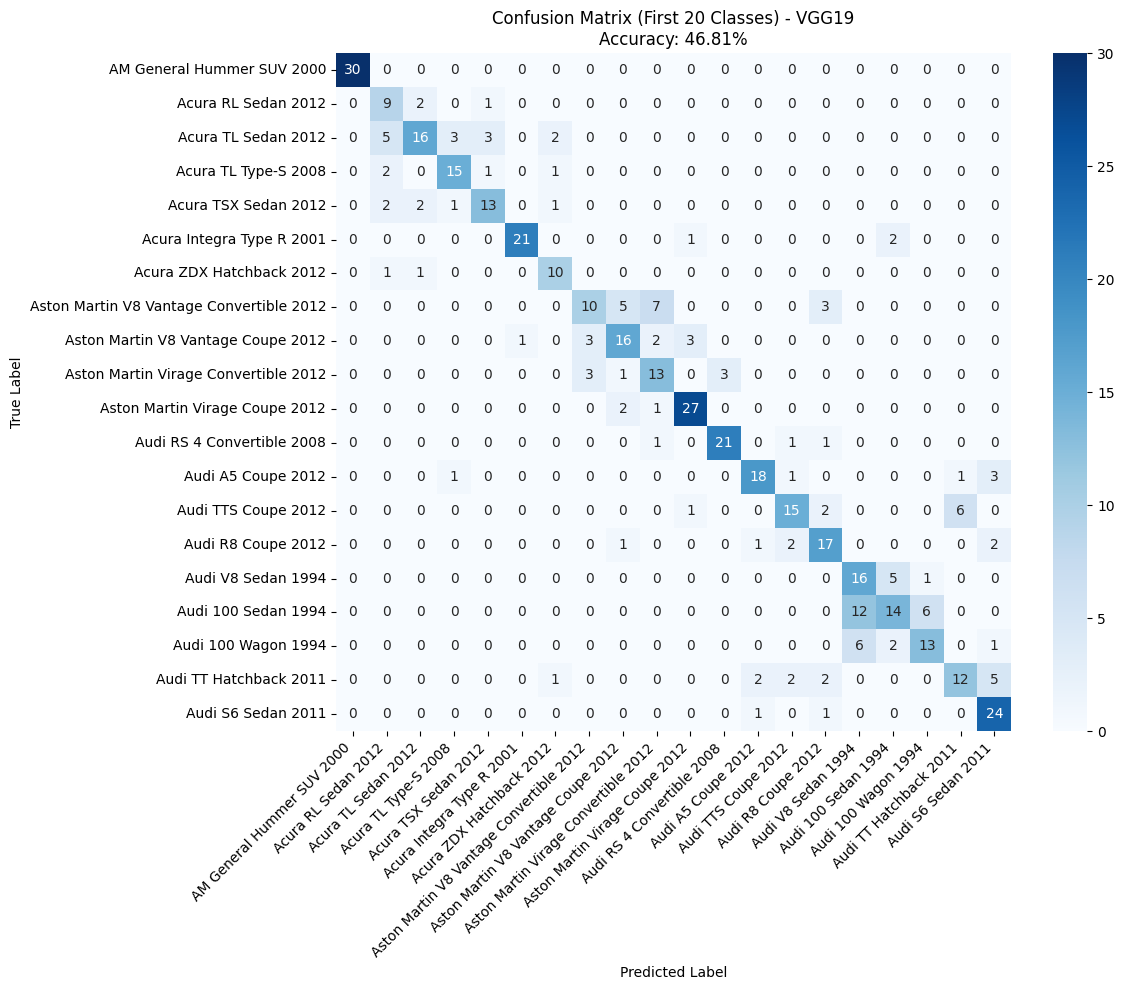

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torchvision import models
from datasets import load_dataset
import os

# ✅ IMPORT UNIVERSAL LOADER
from data_preprocessing import get_dataloaders

# ==========================================
# 1. CONFIGURATION
# ==========================================
MODEL_PATH = "vgg19_hf_stanford_cars.pth"
BATCH_SIZE = 32
NUM_CLASSES = 196
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HF_DATASET_ID = "tanganke/stanford_cars"

# ==========================================
# 2. MODEL ARCHITECTURE (Must match training)
# ==========================================
def get_vgg19_model(num_classes):
    # Load VGG19 BN structure
    model = models.vgg19_bn(weights=None) # No need for pre-trained weights here, we load our own
    
    # Reconstruct the custom head
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes)
    )
    return model

# ==========================================
# 3. EVALUATION LOGIC
# ==========================================
def evaluate_model():
    print(f"🚀 Starting Evaluation on {DEVICE}...")

    # --- 1. LOAD DATA ---
    # We use get_dataloaders to get the standardized test set
    _, _, test_dl = get_dataloaders(batch_size=BATCH_SIZE)
    
    # Load class names for pretty reporting
    print("Loading class names from Hugging Face...")
    ds_info = load_dataset(HF_DATASET_ID, split='train')
    class_names = ds_info.features['label'].names
    
    # --- 2. LOAD MODEL ---
    if not os.path.exists(MODEL_PATH):
        print(f"❌ Error: Model file '{MODEL_PATH}' not found.")
        return

    print(f"Loading weights from {MODEL_PATH}...")
    model = get_vgg19_model(NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    # --- 3. INFERENCE LOOP ---
    print("Running Inference...")
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_dl):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if i % 10 == 0:
                print(f"   Processed batch {i}/{len(test_dl)}...")

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # --- 4. METRICS & VISUALIZATION ---
    print("\n" + "="*30)
    print("       TEST RESULTS       ")
    print("="*30)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Overall Accuracy: {acc*100:.2f}%")

    # Classification Report
    print("\n📊 Generating Detailed Report...")
    report_dict = classification_report(
        all_labels, 
        all_preds, 
        target_names=class_names, 
        output_dict=True, 
        zero_division=0
    )
    report_df = pd.DataFrame(report_dict).transpose()

    print("\n--- Top 5 Best Classified Cars ---")
    print(report_df.sort_values(by='f1-score', ascending=False).head(5)[['precision', 'recall', 'f1-score', 'support']])

    print("\n--- Top 5 Worst Classified Cars ---")
    classes_only = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    print(classes_only.sort_values(by='f1-score', ascending=True).head(5)[['precision', 'recall', 'f1-score', 'support']])

    # Confusion Matrix
    print("\n🎨 Plotting Confusion Matrix (First 20 Classes)...")
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(12, 10))
    # We plot only the first 20 classes to make it readable
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names[:20], yticklabels=class_names[:20])
    plt.title(f"Confusion Matrix (First 20 Classes) - VGG19\nAccuracy: {acc*100:.2f}%")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_model()